# Support Center Queue ... Stochastic Sim. Phase 4

 
- Make G/G/k function

## Let's load up some common code modules before we begin

In [78]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

### Let's define some functions to return random variables from different distributions

In [79]:
# returns a random exponential random variable rounded up to a positive integer
def exponential(mean):
    # usint math.ceil will round up all floating point numbers
    return math.ceil(np.random.exponential(mean))
# returns a uniform random integer between low to high inclusive of low and high
def uniform(low,high):
    return np.random.randint(low,high+1)
# returns a random normal random variable rounded up and truncated if necessary to a positive integer
def normal(mean,sigma):
    # usint math.ceil will round up all floating point numbers
    return max(math.ceil(np.random.normal(mean,sigma)),1)
# returns a triangular random variable rounded up and truncated if necessary to a positive integer
def triangular(left,mode,right):
    return max(round(np.random.triangular(left,mode,right)),1)

In [80]:
triangular(1,2,3)

2

In [81]:
uniform(2,4)

4

In [82]:
exponential(10)

6

In [83]:
normal(50,25)

45

## Let's load our data into Python data structures

In [84]:
# Create NUMBER_OF_ARRIVALS arrivals with interarrival times 
# Exponentially distributed with mean MEAN_TIME_BETWEEN_ARRIVALS
# And service times exponentially distributed with MEAN_SERVICE_TIME
NUMBER_OF_ARRIVALS = 10000
MEAN_TIME_BETWEEN_ARRIVALS = 200
MEAN_SERVICE_TIME = 190

# Set this to True to print out some debug info
DEBUG = False

job_list = []
# If you specify a seed, here 55, then the random numbers will be the same each run
#np.random.seed(55)

for i in range(NUMBER_OF_ARRIVALS):
    # create a new job object, an empty dictionary object
    new_job = {}
    
    # Put the first arrival at time 0
    if (i==0):
        new_job['arrival_time'] = 0
    else:
        # note arrival_jobs[-1] returns the last job in the arrival_jobs list 
        last_arrival_time = job_list[-1]['arrival_time']
        next_arrival_time = last_arrival_time +  exponential(MEAN_TIME_BETWEEN_ARRIVALS)
        new_job['arrival_time'] = next_arrival_time
        
    job_list.append(new_job)

# Let's inspect the first few arrival times
pprint(job_list[:20],indent=4)


[   {'arrival_time': 0},
    {'arrival_time': 145},
    {'arrival_time': 661},
    {'arrival_time': 1208},
    {'arrival_time': 1444},
    {'arrival_time': 1735},
    {'arrival_time': 2024},
    {'arrival_time': 2257},
    {'arrival_time': 2303},
    {'arrival_time': 2382},
    {'arrival_time': 2513},
    {'arrival_time': 2700},
    {'arrival_time': 2767},
    {'arrival_time': 2843},
    {'arrival_time': 2925},
    {'arrival_time': 3117},
    {'arrival_time': 3164},
    {'arrival_time': 3589},
    {'arrival_time': 3799},
    {'arrival_time': 3965}]


## We will now loop through time, with a variable called  `time_period`

In [85]:
def is_simulation_over(completed_jobs):
#     return len(completed_jobs) == len(arrival_times)
    return len(completed_jobs) == NUMBER_OF_ARRIVALS
      
def is_unprocessed_job_remaining(job_list):
    return len(job_list) > 0

def next_arrival_at_time(job_list,time):
    return job_list[0]['arrival_time'] == time

def is_job_in_service(job_in_service):
    return job_in_service != None

def is_job_remaining_in_queue(jobs_in_queue):
    return len(jobs_in_queue) > 0

def is_job_complete(job_in_service,time_period):
    return job_in_service["start_service_time"] + job_in_service["service_duration"] == time_period
    
def set_job_in_service_duration(job_in_service, mean_service_time):
    # Pop the next service time off the service_times list, and set in service job dictionary
    # job_in_service["service_duration"] = service_durations.pop(0)
    job_in_service["service_duration"] =  exponential(mean_service_time)
    
def set_job_start_service_time(job_in_service, time_period):
    job_in_service["start_service_time"] =  time_period
    
def set_job_in_service_completion_time(job_in_service, time_period):
    job_in_service["service_completion_time"] = time_period
    
def add_job_to_next_arrivals(next_arrival_list,arrival_time):
    new_job = {'arrival_time': arrival_time}
    next_arrival_list.append(new_job)


## The ggk function

In [86]:
def ggk(job_list,mean_service_time,num_servers):
    # initialize job_in_service as an array of size num_servers, each with value None
    job_in_service = [None]*num_servers 
    # job_completion_times is a list holding when jobs complete service
    completed_jobs = []
    # job_queue is a list to hold jobs that have arrived and are waiting for service
    jobs_in_queue = []
    #  make a list of jobs that can serve as arrivals to another process
    next_arrivals = []
    #  We will increment time_period as simulation proceeds
    time_period = 0
    print('Begin simulation loop')
    while not is_simulation_over(completed_jobs):
        DEBUG and print('Time Period:',time_period)
        #
        # PROCESS POSSIBLE ARRIVAL TO QUEUE
        #
        if (is_unprocessed_job_remaining(job_list) and next_arrival_at_time(job_list,time_period)):
            DEBUG and print('** Process Arrival at time',time_period)

            # remove first job from arrival_jobs
            job_moving_to_queue = job_list.pop(0)
            # append job to end of jobs_in_queue
            jobs_in_queue.append(job_moving_to_queue)
        #
        # PROCESS POSSIBLE SERVICE COMPLETION
        #
        # loop through all servers
        for server_num in range(num_servers):
            if (is_job_in_service(job_in_service[server_num]) and is_job_complete(job_in_service[server_num],time_period)):
                DEBUG and print('** Process Departure at time',time_period)

                # record time of completion
                set_job_in_service_completion_time(job_in_service[server_num],time_period)

                # add job to departure_times list
                completed_jobs.append(job_in_service[server_num])
                # add job to next_arrivals list
                add_job_to_next_arrivals(next_arrivals,time_period)
                # Free up our server
                job_in_service[server_num] = None
        #
        # PROCESS POSSIBLE START OF SERVICE, DEPARTURE FROM QUEUE
        # loop through all servers
        for server_num in range(num_servers):
            if (not is_job_in_service(job_in_service[server_num]) and is_job_remaining_in_queue(jobs_in_queue)):

                DEBUG and print('** Process Start of Service at time:',time_period)
                # remove first job from queue
                job_in_service[server_num] = jobs_in_queue.pop(0)
                # Place in service by setting start and duration  
                set_job_start_service_time(job_in_service[server_num],time_period)
                set_job_in_service_duration(job_in_service[server_num],mean_service_time)
        #
        # Increment the time_period before going back to top of loop
        time_period = time_period + 1
    return completed_jobs,next_arrivals

In [87]:
completed_jobs, next_arrivals = ggk(job_list,MEAN_SERVICE_TIME,2)
pprint(completed_jobs[:20],indent=4)
pprint(next_arrivals[:20],indent=4)

Begin simulation loop
[   {   'arrival_time': 0,
        'service_completion_time': 119,
        'service_duration': 119,
        'start_service_time': 0},
    {   'arrival_time': 661,
        'service_completion_time': 708,
        'service_duration': 47,
        'start_service_time': 661},
    {   'arrival_time': 145,
        'service_completion_time': 828,
        'service_duration': 683,
        'start_service_time': 145},
    {   'arrival_time': 1208,
        'service_completion_time': 1401,
        'service_duration': 193,
        'start_service_time': 1208},
    {   'arrival_time': 1444,
        'service_completion_time': 1526,
        'service_duration': 82,
        'start_service_time': 1444},
    {   'arrival_time': 1735,
        'service_completion_time': 1817,
        'service_duration': 82,
        'start_service_time': 1735},
    {   'arrival_time': 2024,
        'service_completion_time': 2158,
        'service_duration': 134,
        'start_service_time': 2024},
    {  

### Let's inspect the total system time

In [88]:
system_time=[]
for job in completed_jobs:
    system_time.append(job['service_completion_time']-job['arrival_time'])
#
pprint(system_time[:20])

[119,
 47,
 683,
 193,
 82,
 82,
 134,
 185,
 189,
 66,
 39,
 658,
 420,
 263,
 465,
 459,
 76,
 894,
 57,
 123]


In [89]:
print('The average system time is:',np.mean(system_time))

The average system time is: 245.8241


### Compare to M/M/1 theoretical average time in system
- $CT = \frac{1}{\mu - \lambda}$
- Here, $\mu$ is the average service rate, 1/MEAN_SERVICE_TIME
- And $\lambda$ is the average arrival rate, 1/MEAN_TIME_BETWEEN_ARRIVALS

In [90]:
print('The theoretical average system time is:',1/( (1/MEAN_SERVICE_TIME) - (1/MEAN_TIME_BETWEEN_ARRIVALS) ))

The theoretical average system time is: 3800.000000000003


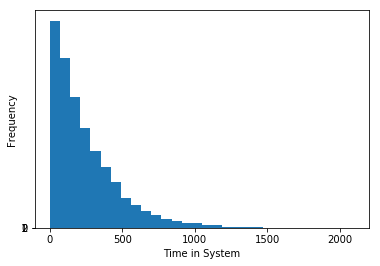

In [91]:
# Tinker with number of bins, until it looks right
plt.hist(system_time,bins=30)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

## The NumPy package provides lots of statistical methods, we call it with `np`

In [92]:
np.max(system_time)

2098

In [93]:
# 50th percentile, or median
np.percentile(system_time,50)

181.0

In [94]:
np.median(system_time)

181.0

In [95]:
np.std(system_time)

229.4503736305304

# Paramount
1.  We can simulate this pretty well now, queue for multiple cooks, then for multiple seats

# Homework/In-class work

1. ?
